In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten, Dense 

# Get the movielens database

In [0]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip -n ml-20m.zip
!ls

--2019-12-15 14:29:54--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  17.1MB/s    in 12s     

2019-12-15 14:30:07 (15.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         
ml-20m	ml-20m.zip  sample_data


In [0]:
# Read in movie ratings
df_r = pd.read_csv('ml-20m/ratings.csv')
df_r.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
# Get user IDs, movie IDs, and ratings as separate arrays
# Recreate userId and movieId, to make sure there aren't skipped ids
df_r.userId = pd.Categorical(df_r.userId)
users = df_r.userId.cat.codes.values
df_r.movieId = pd.Categorical(df_r.movieId)
movies = df_r.movieId.cat.codes.values
ratings = df_r.rating.values

In [0]:
# Split into train and test sets
u_train, u_test, m_train, m_test, y_train, y_test = train_test_split(users, movies, ratings, train_size=0.8)

# Center ratings between (-0.8, +1.)
# Lowest rating is 0.5, so lower centered value is -0.8, not -1.
scaling_factor = 2.5
y_train = y_train / scaling_factor - 1
y_test = y_test / scaling_factor - 1

In [0]:
# Read in the movie database to get titles
df_m = pd.read_csv('ml-20m/movies.csv')
df_m.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# Define a function to retrieve movie titles from the new ides that we defined
# Note that we need two mappings: from cat.codes.values to cat.codes,
# and from cat.codes (i.e. the original movieId) to titles.
def get_title(m_ids):
  return [df_m.title[df_m.movieId == df_r.movieId.cat.categories[m_id]].iloc[0] for m_id in m_ids]

In [0]:
# Example
get_title(range(5))

['Toy Story (1995)',
 'Jumanji (1995)',
 'Grumpier Old Men (1995)',
 'Waiting to Exhale (1995)',
 'Father of the Bride Part II (1995)']

# Build and train a recommender system

In [0]:
embedding_dim = 10
n_users = len(set(users))
n_movies = len(set(movies))

# Input layers
i_u = Input((1,))
i_m = Input((1,))

# Embedding layers
u = Embedding(n_users, embedding_dim)(i_u)
m = Embedding(n_movies, embedding_dim)(i_m)

# Flatten and Concatenate
u = Flatten()(u)
m = Flatten()(m)
x = Concatenate()([u, m])

# Regression
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)

# Compile the model
model = Model([i_u, i_m], x)
model.compile(
    # optimizer=tf.optimizers.Adam(learning_rate=0.01),
    optimizer=tf.optimizers.SGD(lr=0.1, momentum=0.9),  # faster
    loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
r = model.fit([u_train, m_train], y_train,
              validation_data=([u_test, m_test], y_test),
              batch_size=2048,
              epochs=10)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/10
16000210/16000210 [==============================] - 78s 5us/sample - loss: 0.1333 - val_loss: 0.1242
Epoch 2/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1207 - val_loss: 0.1195
Epoch 3/10
16000210/16000210 [==============================] - 76s 5us/sample - loss: 0.1174 - val_loss: 0.1174
Epoch 4/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1150 - val_loss: 0.1152
Epoch 5/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1127 - val_loss: 0.1136
Epoch 6/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1109 - val_loss: 0.1122
Epoch 7/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1096 - val_loss: 0.1118
Epoch 8/10
16000210/16000210 [==============================] - 77s 5us/sample - loss: 0.1087 - val_loss: 0.1109
Epoch 9/10
16000210/16000210 [===========

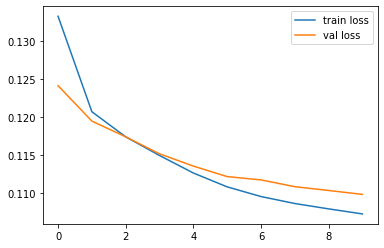

In [0]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

For comparison:

1.   [MovieLens 20M using Factorization Machine](https://support.treasuredata.com/hc/en-us/articles/360001260847-MovieLens-20m-Rating-Prediction-using-Factorization-Machine) (mse: 0.64)
2.   [MovieLens 20M using Autoencoders](https://arxiv.org/pdf/1606.07659.pdf): (mse: 0.66)


Source: https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset




In [0]:
# Loss scaled up, for a proper comparison
mse = (scaling_factor ** 2) * r.history['val_loss'][-1] 
print(f"mse: {mse:.2f}")

mse: 0.69


Example of how to use the recommender

In [0]:
# Compare rating prediction for user 0 from train set (the recommender has seen them)
n = 5
u0 = np.where(u_train == 0)
p_train_u0 = model.predict([u_train[u0], m_train[u0]]).flatten()
recommended = set(get_title(np.argsort(-p_train_u0)[:n]))
preferred = set(get_title(np.argsort(-y_train[u0])[:n]))
print(f"Recommended (first {n}): {recommended}")
print(f"Preferred   (first {n}): {preferred}")
print(f"Recommended but not preferred: {recommended - preferred}")
print(f"Preferred but not recommended: {preferred - recommended}")

Recommended (first 5): {'Usual Suspects, The (1995)', 'Othello (1995)', 'Dead Man Walking (1995)', 'Flirting With Disaster (1996)', 'Nueba Yol (1995)'}
Preferred   (first 5): {'Othello (1995)', 'Dead Man Walking (1995)', 'Kicking and Screaming (1995)', 'Flirting With Disaster (1996)', 'Black Sheep (1996)'}
Recommended but not preferred: {'Usual Suspects, The (1995)', 'Nueba Yol (1995)'}
Preferred but not recommended: {'Kicking and Screaming (1995)', 'Black Sheep (1996)'}


In [0]:
# Compare rating prediction for user 0 from test set (the recommender has not seen them)
n = 5
u0 = np.where(u_test == 0)
p_test_u0 = model.predict([u_test[u0], m_test[u0]]).flatten()
recommended = set(get_title(np.argsort(-p_test_u0)[:n]))
preferred = set(get_title(np.argsort(-y_test[u0])[:n]))
print(f"Recommended  (first {n}): {recommended}")
print(f"Preferred    (first {n}): {preferred}")
print(f"Recommended but not preferred: {recommended - preferred}")
print(f"Preferred but not recommended: {preferred - recommended}")

Recommended  (first 5): {'Copycat (1995)', 'Cry, the Beloved Country (1995)', 'Powder (1995)', 'Carrington (1995)', 'Sabrina (1995)'}
Preferred    (first 5): {'Copycat (1995)', 'Othello (1995)', 'Ace Ventura: When Nature Calls (1995)', 'Now and Then (1995)', 'Money Train (1995)'}
Recommended but not preferred: {'Cry, the Beloved Country (1995)', 'Carrington (1995)', 'Sabrina (1995)', 'Powder (1995)'}
Preferred but not recommended: {'Now and Then (1995)', 'Othello (1995)', 'Money Train (1995)', 'Ace Ventura: When Nature Calls (1995)'}
